# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

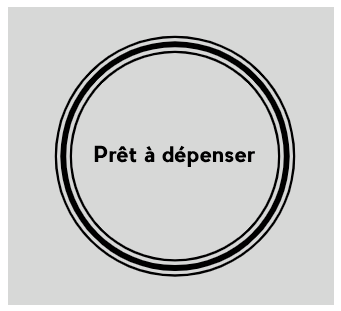

 # <span class='bg-primary'>P7_01_05 - MODELISATION</span>

Ce notebook traite de la modélisation

En particulier :

- **** : 

***
Sources
***
[Métriques](https://www.deepl.com/fr/translator#en/fr/10.%20F-score%0ASimply%20put%2C%20it%20combines%20precision%20and%20recall%20into%20one%20metric.%20The%20higher%20the%20score%20the%20better%20our%20model%20is.%20You%20can%20calculate%20it%20in%20the%20following%20way%3A%0A)

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [36]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

In [2]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import os
# import outils_data
# import outils_preprocessing
# import outils_model
# import eda_kernel_fonctions
import pickle

import matplotlib.pyplot as plt

# Modelisation
import pycaret
from pycaret.classification import *
# import lightgbm as lgb
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

# Warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Pycaret               : ' + pycaret.__version__)
# print('Lightgbm              : ' + lgb.__version__)
# print('Outils dataframe      : ' + outils_data.__version__)
# print('Outils pré-processing : ' + outils_preprocessing.__version__)
# print('Outils model          : ' + outils_model.__version__)
# print('EDA Kernel fonctions  : ' + eda_kernel_fonctions.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Pycaret               : 2.3.0
Lancé le           : 2021-07-31T10:34:17.813577


In [52]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement des jeux de données</span>

**Chargement des dataframes issus du pré-processing**

<span style='background:Moccasin'>**Train_set/test_set**</span>

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [4]:
fic_sav_train_set = \
    '../sauvegarde/features-selection/train_set.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 104)

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [5]:
fic_sav_test_set = \
    '../sauvegarde/features-selection/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 103)

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set_sans_var_magique** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [6]:
fic_sav_train_set_sans = \
    '../sauvegarde/features-selection/train_set_sans_var_magique.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set_sans_var_magique = pickle.load(df_appli_train_set_sans)
train_set_sans_var_magique.shape

(307507, 108)

- **test_set_sans_var_magique** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [7]:
fic_sav_test_set_sans = \
    '../sauvegarde/features-selection/test_set_sans_var_magique.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set_sans_var_magique = pickle.load(df_appli_test_set_sans)
test_set_sans_var_magique.shape

(48744, 107)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : médiane,
    - valeurs qualitatives : mode.

<span style='background:Moccasin'>**Train_imp1_set/test_imp1_set**</span>

- **train_imp1_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [8]:
fic_sav_train_imp1_set = \
    '../sauvegarde/features-selection/train_imp1_set.pickle'
# Chargement de train_imp1_set
with open(fic_sav_train_imp1_set, 'rb') as df_appli_train_imp1_set:
    train_imp1_set = pickle.load(df_appli_train_imp1_set)
train_imp1_set.shape

(307507, 108)

- **test_imp1_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [9]:
fic_sav_test_imp1_set = \
    '../sauvegarde/features-selection/test_imp1_set.pickle'
# Chargement de test_imp1_set
with open(fic_sav_test_imp1_set, 'rb') as df_appli_test_imp1_set:
    test_imp1_set = pickle.load(df_appli_test_imp1_set)
test_imp1_set.shape

(48744, 107)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : constante 0,
    - valeurs qualitatives : constante XNA.

<span style='background:Moccasin'>**Train_imp2_set/test_imp2_set**</span>

- **train_imp2_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [10]:
fic_sav_train_imp2_set = \
    '../sauvegarde/features-selection/train_imp2_set.pickle'
# Chargement de train_imp2_set
with open(fic_sav_train_imp2_set, 'rb') as df_appli_train_imp2_set:
    train_imp2_set = pickle.load(df_appli_train_imp2_set)
train_imp2_set.shape

(307507, 97)

- **test_imp2_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [11]:
fic_sav_test_imp2_set = \
    '../sauvegarde/features-selection/test_imp2_set.pickle'
# Chargement de test_imp2_set
with open(fic_sav_test_imp2_set, 'rb') as df_appli_test_imp2_set:
    test_imp2_set = pickle.load(df_appli_test_imp2_set)
test_imp2_set.shape

(48744, 96)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : NaNImputer de la librairie Verstack,
    - valeurs qualitatives : constante XNA.

## <span style='background:Thistle'>3. Première idée sur les modèles avec pycaret</span>

L'idée d'utiliser pycaret est :
- d'avoir une **première impression sur les modèles** avec les hyperparamètres de base pour choisir le modèle à optimiser,
- et de voir l'**impact sur les scores** en fonction des différentes imputation effectuées lors du pré-processing pour choisir le jeu de données à conserver qui donne les meilleurs résultats.

***Note*** :
***
 Paramètre d'initialisation pour les jeux de données déséquilibrés comme c'est notre cas :
- **fix_imbalance** : bool, défaut = False. Lorsque l'ensemble de données d'apprentissage présente une distribution inégale de la classe cible, il peut être équilibré à l'aide de ce paramètre. Lorsqu'il est défini sur True, SMOTE (Synthetic Minority Over-sampling Technique) est appliqué par défaut pour créer des points de données synthétiques pour la classe minoritaire.
- **data_split_stratify** : bool ou liste, par défaut = False. Contrôle la stratification pendant 'train_test_split'. Si la valeur est True, la stratification se fera sur la colonne cible. Pour stratifier sur d'autres colonnes, passez une liste de noms de colonnes. Ignoré lorsque data_split_shuffle est False.

### <span style='background:PowderBlue'>3.1. Pycaret : train_set</span>

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [45]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 108)"
5,Missing Values,False
6,Numeric Features,107
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [46]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7685,0.0683,0.4452,0.1184,0.0991,0.1498,65.9950
xgboost,Extreme Gradient Boosting,0.9158,0.7562,0.0800,0.3930,0.1329,0.1086,0.1481,51.9390
lightgbm,Light Gradient Boosting Machine,0.9162,0.7550,0.0503,0.3640,0.0883,0.0701,0.1104,10.2220
rf,Random Forest Classifier,0.9124,0.7342,0.0586,0.2897,0.0974,0.0722,0.0987,49.9230
gbc,Gradient Boosting Classifier,0.9019,0.7168,0.1046,0.2466,0.1468,0.1037,0.1146,125.7170
et,Extra Trees Classifier,0.9018,0.7124,0.0947,0.2331,0.1347,0.0924,0.1030,42.0720
ada,Ada Boost Classifier,0.8723,0.6979,0.1959,0.2010,0.1984,0.1290,0.1291,32.8100
lda,Linear Discriminant Analysis,0.7316,0.6739,0.4904,0.1484,0.2278,0.1185,0.1498,7.8820
knn,K Neighbors Classifier,0.6839,0.5661,0.3829,0.1040,0.1636,0.0419,0.0556,116.7160
nb,Naive Bayes,0.1113,0.5592,0.9762,0.0816,0.1506,0.0019,0.0174,5.3040


In [47]:
# Le meilleur modèle ?
print(best_models)

In [48]:
# Sauvegarde des scores
df_best_models_scores_sans = pull()
df_best_models_scores_sans

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7685,0.0683,0.4452,0.1184,0.0991,0.1498,65.995
xgboost,Extreme Gradient Boosting,0.9158,0.7562,0.0800,0.3930,0.1329,0.1086,0.1481,51.939
lightgbm,Light Gradient Boosting Machine,0.9162,0.7550,0.0503,0.3640,0.0883,0.0701,0.1104,10.222
rf,Random Forest Classifier,0.9124,0.7342,0.0586,0.2897,0.0974,0.0722,0.0987,49.923
gbc,Gradient Boosting Classifier,0.9019,0.7168,0.1046,0.2466,0.1468,0.1037,0.1146,125.717
et,Extra Trees Classifier,0.9018,0.7124,0.0947,0.2331,0.1347,0.0924,0.1030,42.072
ada,Ada Boost Classifier,0.8723,0.6979,0.1959,0.2010,0.1984,0.1290,0.1291,32.810
lda,Linear Discriminant Analysis,0.7316,0.6739,0.4904,0.1484,0.2278,0.1185,0.1498,7.882
knn,K Neighbors Classifier,0.6839,0.5661,0.3829,0.1040,0.1636,0.0419,0.0556,116.716
nb,Naive Bayes,0.1113,0.5592,0.9762,0.0816,0.1506,0.0019,0.0174,5.304


In [49]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores_sans = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
with open(fic_sav_train_set_scores_sans, 'wb') as f:
    pickle.dump(df_best_models_scores_sans, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 80 variables au lieu des 104 variables du train_set ?

In [16]:
fic_sav_train_set_sans_small = \
    '../sauvegarde/features-selection/train_set_sans_var_magique_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_sans_small, 'rb') as df_appli_train_set_sans_small:
    train_set_sans_var_magique_small = \
        pickle.load(df_appli_train_set_sans_small)
train_set_sans_var_magique_small.shape

(307507, 80)

In [22]:
fic_sav_test_set_sans_small = \
    '../sauvegarde/features-selection/test_set_sans_var_magique_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_sans_small, 'rb') as df_appli_test_sans_set_small:
    test_set_sans_var_magique_small = \
        pickle.load(df_appli_test_sans_set_small)
test_set_sans_var_magique_small.shape

(48744, 79)

In [23]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans_small',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 80)"
5,Missing Values,False
6,Numeric Features,79
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_sans_small = compare_models(
    include=['catboost', 'xgboost', 'lightgbm'],
    sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9174,0.7665,0.0725,0.4318,0.1241,0.1033,0.1510,63.1870
xgboost,Extreme Gradient Boosting,0.9149,0.7564,0.0824,0.3757,0.1351,0.1093,0.1453,41.2410
lightgbm,Light Gradient Boosting Machine,0.9152,0.7520,0.0541,0.3390,0.0932,0.0727,0.1083,7.0440


In [25]:
# Le meilleur modèle ?
print(best_models_sans_small)

In [26]:
# Sauvegarde des scores
df_best_models_scores_sans_small = pull()
df_best_models_scores_sans_small

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9174,0.7665,0.0725,0.4318,0.1241,0.1033,0.1510,63.187
xgboost,Extreme Gradient Boosting,0.9149,0.7564,0.0824,0.3757,0.1351,0.1093,0.1453,41.241
lightgbm,Light Gradient Boosting Machine,0.9152,0.7520,0.0541,0.3390,0.0932,0.0727,0.1083,7.044


In [27]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_sans_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
with open(fic_sav_train_set_scores_sans_small, 'wb') as f:
    pickle.dump(df_best_models_scores_sans_small, f, pickle.HIGHEST_PROTOCOL)

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [10]:
# Classification PyCaret - Initialisation
exp_name = setup(data=train_set,
                 target='TARGET',
                 fix_imbalance=True,
                 data_split_stratify=True,
                 session_id=21,
                 log_experiment=True,
                 experiment_name='train_set',
                 silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 104)"
5,Missing Values,False
6,Numeric Features,103
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9180,0.7763,0.0716,0.4501,0.1236,0.1037,0.1546,64.2930
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.1270
xgboost,Extreme Gradient Boosting,0.9159,0.7647,0.0819,0.3981,0.1359,0.1114,0.1514,49.8680
rf,Random Forest Classifier,0.9124,0.7500,0.0634,0.2994,0.1046,0.0786,0.1058,48.3770
gbc,Gradient Boosting Classifier,0.9013,0.7365,0.1135,0.2525,0.1566,0.1121,0.1223,118.7920
et,Extra Trees Classifier,0.8999,0.7317,0.1147,0.2445,0.1561,0.1103,0.1193,40.7100
ada,Ada Boost Classifier,0.8745,0.7102,0.1853,0.2005,0.1925,0.1247,0.1248,31.3740
lda,Linear Discriminant Analysis,0.7544,0.6942,0.5061,0.1657,0.2496,0.1457,0.1784,6.7030
knn,K Neighbors Classifier,0.6853,0.5642,0.3798,0.1039,0.1631,0.0416,0.0549,103.8520
nb,Naive Bayes,0.1102,0.5599,0.9765,0.0815,0.1505,0.0018,0.0163,4.5900


3:40: E261 at least two spaces before inline comment
4:29: E124 29


In [12]:
# Le meilleur modèle ?
print(best_models)

In [15]:
# Sauvegarde des scores
df_best_models_scores = pull()
df_best_models_scores

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9180,0.7763,0.0716,0.4501,0.1236,0.1037,0.1546,64.293
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.127
xgboost,Extreme Gradient Boosting,0.9159,0.7647,0.0819,0.3981,0.1359,0.1114,0.1514,49.868
rf,Random Forest Classifier,0.9124,0.7500,0.0634,0.2994,0.1046,0.0786,0.1058,48.377
gbc,Gradient Boosting Classifier,0.9013,0.7365,0.1135,0.2525,0.1566,0.1121,0.1223,118.792
et,Extra Trees Classifier,0.8999,0.7317,0.1147,0.2445,0.1561,0.1103,0.1193,40.710
ada,Ada Boost Classifier,0.8745,0.7102,0.1853,0.2005,0.1925,0.1247,0.1248,31.374
lda,Linear Discriminant Analysis,0.7544,0.6942,0.5061,0.1657,0.2496,0.1457,0.1784,6.703
knn,K Neighbors Classifier,0.6853,0.5642,0.3798,0.1039,0.1631,0.0416,0.0549,103.852
nb,Naive Bayes,0.1102,0.5599,0.9765,0.0815,0.1505,0.0018,0.0163,4.590


In [17]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_set_scores.pickle'
with open(fic_sav_train_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 70 variables au lieu des 108 variables du train_set ?

In [28]:
fic_sav_train_set_small = \
    '../sauvegarde/features-selection/train_set_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_small, 'rb') as df_appli_train_set_small:
    train_set_small = \
        pickle.load(df_appli_train_set_small)
train_set_small.shape

(307507, 70)

In [30]:
fic_sav_test_set_small = \
    '../sauvegarde/features-selection/test_set_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_small, 'rb') as df_appli_test_set_small:
    test_set_small = \
        pickle.load(df_appli_test_set_small)
test_set_small.shape

(48744, 69)

In [31]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_small',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 70)"
5,Missing Values,False
6,Numeric Features,69
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_small = compare_models(
    include=['catboost', 'xgboost', 'lightgbm'],
    sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9171,0.7714,0.0742,0.4215,0.1262,0.1046,0.1502,57.5570
lightgbm,Light Gradient Boosting Machine,0.9146,0.7635,0.0579,0.3326,0.0987,0.0766,0.1104,6.4490
xgboost,Extreme Gradient Boosting,0.9141,0.7600,0.0865,0.3652,0.1398,0.1123,0.1457,34.9700


In [33]:
# Le meilleur modèle ?
print(best_models_small)

In [34]:
# Sauvegarde des scores
df_best_models_scores_small = pull()
df_best_models_scores_small

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9171,0.7714,0.0742,0.4215,0.1262,0.1046,0.1502,57.557
lightgbm,Light Gradient Boosting Machine,0.9146,0.7635,0.0579,0.3326,0.0987,0.0766,0.1104,6.449
xgboost,Extreme Gradient Boosting,0.9141,0.7600,0.0865,0.3652,0.1398,0.1123,0.1457,34.970


In [35]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
with open(fic_sav_train_set_scores_small, 'wb') as f:
    pickle.dump(df_best_models_scores_small, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.2. Pycaret : train_imp1_set</span>

In [19]:
# Classification PyCaret - Initialisation
exp_name_imp1 = setup(data=train_imp1_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp1_set',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 108)"
5,Missing Values,False
6,Numeric Features,107
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp1 = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7769,0.0735,0.4477,0.1263,0.1060,0.1561,65.2990
lightgbm,Light Gradient Boosting Machine,0.9169,0.7672,0.0539,0.3937,0.0947,0.0768,0.1214,8.5700
xgboost,Extreme Gradient Boosting,0.9157,0.7645,0.0838,0.3948,0.1382,0.1133,0.1523,52.7060
rf,Random Forest Classifier,0.9098,0.7490,0.0844,0.2954,0.1313,0.0989,0.1210,47.5610
gbc,Gradient Boosting Classifier,0.9008,0.7294,0.1248,0.2605,0.1687,0.1228,0.1323,138.7630
et,Extra Trees Classifier,0.8976,0.7281,0.1250,0.2411,0.1646,0.1158,0.1230,40.1750
ada,Ada Boost Classifier,0.8700,0.7092,0.2073,0.2024,0.2048,0.1341,0.1341,31.8560
lda,Linear Discriminant Analysis,0.7599,0.6885,0.4791,0.1634,0.2437,0.1401,0.1690,5.8200
knn,K Neighbors Classifier,0.6922,0.5717,0.3834,0.1071,0.1675,0.0472,0.0618,138.4010
lr,Logistic Regression,0.6909,0.5708,0.3764,0.1050,0.1641,0.0435,0.0570,10.3380


In [21]:
# Le meilleur modèle ?
print(best_models_imp1)

In [22]:
# Sauvegarde des scores
df_best_models_scores_imp1 = pull()
df_best_models_scores_imp1

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7769,0.0735,0.4477,0.1263,0.1060,0.1561,65.299
lightgbm,Light Gradient Boosting Machine,0.9169,0.7672,0.0539,0.3937,0.0947,0.0768,0.1214,8.570
xgboost,Extreme Gradient Boosting,0.9157,0.7645,0.0838,0.3948,0.1382,0.1133,0.1523,52.706
rf,Random Forest Classifier,0.9098,0.7490,0.0844,0.2954,0.1313,0.0989,0.1210,47.561
gbc,Gradient Boosting Classifier,0.9008,0.7294,0.1248,0.2605,0.1687,0.1228,0.1323,138.763
et,Extra Trees Classifier,0.8976,0.7281,0.1250,0.2411,0.1646,0.1158,0.1230,40.175
ada,Ada Boost Classifier,0.8700,0.7092,0.2073,0.2024,0.2048,0.1341,0.1341,31.856
lda,Linear Discriminant Analysis,0.7599,0.6885,0.4791,0.1634,0.2437,0.1401,0.1690,5.820
knn,K Neighbors Classifier,0.6922,0.5717,0.3834,0.1071,0.1675,0.0472,0.0618,138.401
lr,Logistic Regression,0.6909,0.5708,0.3764,0.1050,0.1641,0.0435,0.0570,10.338


In [23]:
# Sauvegarde des scores des best models du train_imp1_set
fic_sav_train_imp1_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
with open(fic_sav_train_imp1_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp1, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.3. Pycaret : train_imp2_set</span>

In [24]:
# Classification PyCaret - Initialisation
exp_name_imp2 = setup(data=train_imp2_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp2_set',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 97)"
5,Missing Values,False
6,Numeric Features,96
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [26]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp2 = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9183,0.7796,0.0723,0.4603,0.1250,0.1054,0.1579,63.1510
lightgbm,Light Gradient Boosting Machine,0.9175,0.7731,0.0466,0.4025,0.0834,0.0679,0.1146,9.1750
xgboost,Extreme Gradient Boosting,0.9162,0.7690,0.0808,0.4044,0.1346,0.1107,0.1521,49.2950
rf,Random Forest Classifier,0.9127,0.7528,0.0614,0.3012,0.1020,0.0767,0.1047,44.7410
gbc,Gradient Boosting Classifier,0.9052,0.7401,0.1025,0.2698,0.1485,0.1089,0.1234,125.9060
et,Extra Trees Classifier,0.9023,0.7371,0.1132,0.2596,0.1576,0.1142,0.1254,37.8280
ada,Ada Boost Classifier,0.8804,0.7253,0.1852,0.2175,0.2000,0.1359,0.1364,30.1030
lda,Linear Discriminant Analysis,0.7547,0.7065,0.5223,0.1694,0.2558,0.1525,0.1874,6.8730
qda,Quadratic Discriminant Analysis,0.1474,0.5692,0.9504,0.0829,0.1525,0.0047,0.0283,8.8330
knn,K Neighbors Classifier,0.6843,0.5652,0.3800,0.1035,0.1627,0.0410,0.0543,103.8960


In [27]:
# Le meilleur modèle ?
print(best_models_imp2)

In [28]:
# Sauvegarde des scores
df_best_models_scores_imp2 = pull()
df_best_models_scores_imp2

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9183,0.7796,0.0723,0.4603,0.1250,0.1054,0.1579,63.151
lightgbm,Light Gradient Boosting Machine,0.9175,0.7731,0.0466,0.4025,0.0834,0.0679,0.1146,9.175
xgboost,Extreme Gradient Boosting,0.9162,0.7690,0.0808,0.4044,0.1346,0.1107,0.1521,49.295
rf,Random Forest Classifier,0.9127,0.7528,0.0614,0.3012,0.1020,0.0767,0.1047,44.741
gbc,Gradient Boosting Classifier,0.9052,0.7401,0.1025,0.2698,0.1485,0.1089,0.1234,125.906
et,Extra Trees Classifier,0.9023,0.7371,0.1132,0.2596,0.1576,0.1142,0.1254,37.828
ada,Ada Boost Classifier,0.8804,0.7253,0.1852,0.2175,0.2000,0.1359,0.1364,30.103
lda,Linear Discriminant Analysis,0.7547,0.7065,0.5223,0.1694,0.2558,0.1525,0.1874,6.873
qda,Quadratic Discriminant Analysis,0.1474,0.5692,0.9504,0.0829,0.1525,0.0047,0.0283,8.833
knn,K Neighbors Classifier,0.6843,0.5652,0.3800,0.1035,0.1627,0.0410,0.0543,103.896


In [29]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_imp2_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
with open(fic_sav_train_imp2_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp2, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.4. Pycaret : bilan</span>

In [37]:
# Scores du train_set avec variable magique
fic_train_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_set_scores.pickle'
# Chargement de train_set
with open(fic_train_set_scores, 'rb') as df_pycaret_train_set:
    df_best_models_scores = pickle.load(df_pycaret_train_set)
df_best_models_scores.shape

(15, 9)

In [38]:
# Scores du train_set sans la variable magique
fic_train_set_scores_sans = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans, 'rb') as df_pycaret_train_set_sans:
    df_best_models_scores_sans = pickle.load(df_pycaret_train_set_sans)
df_best_models_scores_sans.shape

(15, 9)

In [44]:
# Scores du train_set sans variable magique, réduit
fic_train_set_scores_sans_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans_small, 'rb') as df_pycaret_trainsanssmall:
    df_best_models_scores_sans_small = \
        pickle.load(df_pycaret_trainsanssmall)
df_best_models_scores_sans_small.shape

(3, 9)

In [45]:
# Scores du train_set avec variable magique, réduit
fic_train_set_scores_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_small, 'rb') as df_pycaret_train_small:
    df_best_models_scores_small = \
        pickle.load(df_pycaret_train_small)
df_best_models_scores_small.shape

(3, 9)

In [46]:
# Scores du train_imp1_set
fic_train_imp1_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
# Chargement de train_imp1_set
with open(fic_train_imp1_set_scores, 'rb') as df_pycaret_train_imp1_set:
    df_best_models_scores_imp1 = pickle.load(df_pycaret_train_imp1_set)
df_best_models_scores_imp1.shape

(15, 9)

In [47]:
# Scores du train_imp2_set
fic_train_imp2_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
# Chargement de train_imp2_set
with open(fic_train_imp2_set_scores, 'rb') as df_pycaret_train_imp2_set:
    df_best_models_scores_imp2 = pickle.load(df_pycaret_train_imp2_set)
df_best_models_scores_imp2.shape

(15, 9)

In [48]:
# Ajout du jeu de données pour identifier les scores
df_best_models_scores['Jeu_donnees'] = 'train_set'
df_best_models_scores_sans['Jeu_donnees'] = 'train_set_sans'
df_best_models_scores_small['Jeu_donnees'] = 'train_set_small'
df_best_models_scores_sans_small['Jeu_donnees'] = 'train_set_sans_small'
df_best_models_scores_imp1['Jeu_donnees'] = 'train_imp1_set'
df_best_models_scores_imp2['Jeu_donnees'] = 'train_imp2_set'

In [49]:
# Constitution d'un seul dataframes
df_best_models_scores_all = \
    df_best_models_scores.append(df_best_models_scores_sans)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_sans_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp1)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp2)
df_best_models_scores_all.shape

(66, 10)

In [56]:
# Tri avec métrique AUC
df_tri = df_best_models_scores_all.sort_values(by='AUC', ascending=False)
df_tri

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees
catboost,CatBoost Classifier,0.9183,0.7796,0.0723,0.4603,0.1250,0.1054,0.1579,63.151,train_imp2_set
catboost,CatBoost Classifier,0.9179,0.7769,0.0735,0.4477,0.1263,0.1060,0.1561,65.299,train_imp1_set
catboost,CatBoost Classifier,0.9180,0.7763,0.0716,0.4501,0.1236,0.1037,0.1546,64.293,train_set
lightgbm,Light Gradient Boosting Machine,0.9175,0.7731,0.0466,0.4025,0.0834,0.0679,0.1146,9.175,train_imp2_set
catboost,CatBoost Classifier,0.9171,0.7714,0.0742,0.4215,0.1262,0.1046,0.1502,57.557,train_set_small
xgboost,Extreme Gradient Boosting,0.9162,0.7690,0.0808,0.4044,0.1346,0.1107,0.1521,49.295,train_imp2_set
catboost,CatBoost Classifier,0.9179,0.7685,0.0683,0.4452,0.1184,0.0991,0.1498,65.995,train_set_sans
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.127,train_set
lightgbm,Light Gradient Boosting Machine,0.9169,0.7672,0.0539,0.3937,0.0947,0.0768,0.1214,8.570,train_imp1_set
catboost,CatBoost Classifier,0.9174,0.7665,0.0725,0.4318,0.1241,0.1033,0.1510,63.187,train_set_sans_small


**Bilan** : 
***
- **Jeux de données** à utiliser (selon l'imputation effectuée) :
    - Les scores sont légèrement supérieurs pour le jeu de données train_imp2_set que pour le jeu de données train_set.
    - Mais il est difficile d'expliquer l'imputation avec NaNImputer par la librairie verstack à un utilisateur non datascientist alors qu'il est facile d'expliquer l'utilisation de la valeur moyenne pour les variables numériques et le mode ou la valeur la plus utilisée pour les variables catégorielles.
    - L'imputation par la librairie verstack est également beaucoup plus longues (presque 25 minutes au lieu de quelques secondes pour la médiane).
    - les jeux de données train_set/test_set seront utilisés pour entraîner et valider le modèle.
- **Modèles** : en se basant sur la métrique AUC, 3 modèles se détachent :
    - Catboost Classifier,
    - Light Gradient Boosting Machine,
    - Extreme Gradient Boosting Machine.
    - Observons les autres métriques pour départager nos 3 modèles.

In [57]:
mask_model = df_best_models_scores_all['Model'] \
    .isin(['CatBoost Classifier', 'Light Gradient Boosting Machine',
           'Extreme Gradient Boosting'])
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare = df_best_models_scores_all[mask_model & mask_jeu]

- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur. 
- La métrique pour déterminer le **taux de vrais positif** est le Rappel/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
- La métrique **Precision**  mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

***Note :***
***
- Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
- Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximise le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
- Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

[Source](https://www.deepl.com/fr/translator#en/fr/10.%20F-score%0ASimply%20put%2C%20it%20combines%20precision%20and%20recall%20into%20one%20metric.%20The%20higher%20the%20score%20the%20better%20our%20model%20is.%20You%20can%20calculate%20it%20in%20the%20following%20way%3A%0A)

**Choix du modèle**

In [87]:
# Tri avec métrique AUC
df_compare.groupby(['Model','Jeu_donnees']).agg({'AUC' : max}) \
    .sort_values(by=['Model', 'AUC'], ascending=[True, False]).unstack()

AUC                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.7763         0.7685               0.7665          0.7714
Extreme Gradient Boosting          0.7647         0.7562               0.7564          0.7600
Light Gradient Boosting Machine    0.7674         0.7550               0.7520          0.7635

- Léger avantage au modèle Catboost, Lightgbm et xgboost ont des résultats proches.
- Les meilleurs résultats sont obtenus par le train_set et le train_set_small mais les résultats sont assez proches pour tous les jeux de données.

In [89]:
# Tri avec métrique Recall
df_compare.groupby(['Model','Jeu_donnees']).agg({'Recall' : max}) \
    .sort_values(by=['Model', 'Recall'], ascending=[True, False]).unstack()

Recall                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.0716         0.0683               0.0725          0.0742
Extreme Gradient Boosting          0.0819         0.0800               0.0824          0.0865
Light Gradient Boosting Machine    0.0487         0.0503               0.0541          0.0579

- Le meilleur résultat est obtenu par Xgboost, suivi par CatBoost avec un résultat 2 fois meilleur que pour Lightgbm mais le recall peut-être affiné en optimisant le modèle et le seuil de probabilité.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [91]:
# Tri avec métrique Precision
df_compare.groupby(['Model','Jeu_donnees']).agg({'Prec.' : max}) \
    .sort_values(by=['Model', 'Prec.'], ascending=[True, False]).unstack()

Prec.                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.4501         0.4452               0.4318          0.4215
Extreme Gradient Boosting          0.3981         0.3930               0.3757          0.3652
Light Gradient Boosting Machine    0.3737         0.3640               0.3390          0.3326

- Le meilleur résultat est obtenu par CatBoost, suivi par les 2 autres modèles qui ont des résultats proches.
- Au niveau des jeux de données, avantage pour le train_set suivi par  le train_set_sans mais les résultats sont assez proches pour tous les jeux de données.

In [92]:
# Tri avec métrique F1-Score
df_compare.groupby(['Model','Jeu_donnees']).agg({'F1' : max}) \
    .sort_values(by=['Model', 'F1'], ascending=[True, False]).unstack()

F1                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.1236         0.1184               0.1241          0.1262
Extreme Gradient Boosting          0.1359         0.1329               0.1351          0.1398
Light Gradient Boosting Machine    0.0862         0.0883               0.0932          0.0987

- Le meilleur résultat est obtenu par Xgboost, suivi par Catboost, Lightgbm est légèrement à la traîne sauf pour les train_set_small et  train_set_sans_small.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [93]:
# Tri avec métrique Temps
df_compare.groupby(['Model','Jeu_donnees']).agg({'TT (Sec)' : max}) \
    .sort_values(by=['Model', 'TT (Sec)'], ascending=[True, False]).unstack()

TT (Sec)                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                64.293         65.995               63.187          57.557
Extreme Gradient Boosting          49.868         51.939               41.241          34.970
Light Gradient Boosting Machine     9.127         10.222                7.044           6.449

- Lightgbm est le plus rapide (5 fois plus rapide que xgboost et 7 fois plus que Catboost qui est très lent).
- Sans surprise les jeux de données avec moins de variables (small) ont des temps de réponse plus rapides.

**Bilan** :
***
- Les résultats sont meilleurs pour Catboost mais légèrement supérieur pour Xgboost par rapport à Lightgbm, mais le modèle Lightgbm est 7 fois plus rapide que Catboost. Puisque le but est un dashboard interactif, si de nouvelles données sont fournies ou si les données des clients évoluent, le temps d'exécution sera un facteur essentiel pour notre problématique.
- Les métriques peuvent être optimisées en jouant sur l'équilibrage du jeu de données, sur l'optimisation du modèle et sur le réglage du seuil de probabilité.
- Après analyse des résultats et des contraintes de notre problématique, **le modèle retenu sera Lightgbm**.

**Choix du jeu de données**

In [96]:
mask_model = df_best_models_scores_all['Model'] == 'Light Gradient Boosting Machine'
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare_jeu = df_best_models_scores_all[mask_model & mask_jeu]
df_compare_jeu

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.127,train_set
lightgbm,Light Gradient Boosting Machine,0.9162,0.7550,0.0503,0.3640,0.0883,0.0701,0.1104,10.222,train_set_sans
lightgbm,Light Gradient Boosting Machine,0.9146,0.7635,0.0579,0.3326,0.0987,0.0766,0.1104,6.449,train_set_small
lightgbm,Light Gradient Boosting Machine,0.9152,0.7520,0.0541,0.3390,0.0932,0.0727,0.1083,7.044,train_set_sans_small


- La variable magique qui a permis de gagner le concours Kaggle offre un avantage sur l'accuracy mais a de moins bon résultat sur la métrique recall qui est très importante pour notre problématique. Comme elle est difficilement explicable et peut être controversée (comparaison avec d'autres individus) nous utiliserons les datasets sans cette variable sur **le jeu de données non réduit (train_set)**.

**Bilan** :
- Modèle : **Light Gradient Boosting Machine**.
- Jeu de données : **train_set**.